**Model Selection Considerations**

| Data Assumptions | Assumptions Test |
|------|------|
|   Univariate Timeseries | N/A|
|   Normal Distribution | p-test, visual inspection of histograms, q-q plots, box plots |
|   Regular Time Series | domain knowledge/put a groupby on it|

- like most forecasting problems, the uncertainty increases greatly as you predict further into the future. It is best to keep the forecast small. 
- Also auto-arima takes more time to run beacuse its cycles through every

**Use Cases**
- Good for really any type of time series data.

**Dependencies**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 

In [4]:
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

**Load Data**

In [43]:
df = pd.read_csv('data/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


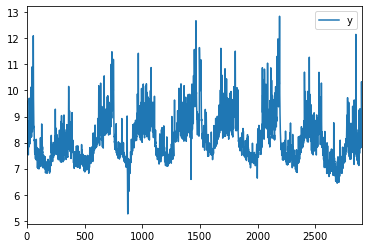

In [44]:
df.plot()

In [45]:
#split dataset into smaller dataset for forecasting
df = df[:(int(len(df)*.2))]
df.tail()

,ds,y
576,2009-08-06,8.172164
577,2009-08-07,7.811568
578,2009-08-08,7.575072
579,2009-08-09,7.658700
580,2009-08-10,7.866339


**Data Preperation: Required Inputs and Format**
- Dataframe with one column of dependent values
- (Required) y : array-like or iterable, shape=(n_samples,)
            The time-series to which to fit the ``ARIMA`` estimator. This may
            either be a Pandas ``Series`` object (statsmodels can internally
            use the dates in the index), or a numpy array. This should be a
            one-dimensional array of floats, and should not contain any
            ``np.nan`` or ``np.inf`` values.
- Don't train on an incomplete cycle preferably 

In [46]:
#preprocessing (since arima takes univariate series as input)
df.drop('ds',axis=1,inplace=True)
print('len dataset:' + str(len(df)))
df.head()

len dataset:581


/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,y
0,9.590761
1,8.519590
2,8.183677
3,8.072467
4,7.893572


In [47]:
#conver data into array
data = df.values

In [51]:
#divide into train and validation set
ts=450
train, test = model_selection.train_test_split(data, train_size=ts)

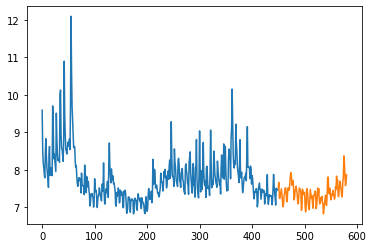

In [52]:
#plotting the data for vis purposes
x_data = range(len(data))
plt.plot(x_data[:ts], train[:])
plt.plot(x_data[ts:], test[:])

**Optional Inputs**
- exogenous : array-like, shape=[n_obs, n_vars], optional (default=None)
            An optional 2-d array of exogenous variables. If provided, these
            variables are used as additional features in the regression
            operation. This should not include a constant or trend. Note that
            if an ``ARIMA`` is fit on exogenous features, it must be provided
            exogenous features for making predictions.
- exogenous definition: An independent variable that affects a model without being affected by it, and whose qualitative characteristics and method of generation are not specified by the model builder. I.E. if you wanted to model the temperature of a soup in a pot, the preprogrammed temperature of the hot plate would be the exogenous variable. 
- Tons of optional arguments listed [here](https://github.com/alkaline-ml/pmdarima/blob/b79db3111e087e6a6a2181de1f267fcd2d953079/pmdarima/arima/auto.py#L69) (source) and [here](https://pkg.robjhyndman.com/forecast/reference/auto.arima.html) (documentation). However, auto-arima should be able to find all of those parameters for you, so you don't have to explicitly define them. 
- My recommendation is to just include the following as optional arguments: 
`(m=1, seasonal=True, stationary=False, trace=True, error_action='ignore', suppress_warnings=True)`

**Input Defaults**
- just a the dependent variable

**Minimal Output**
- Plain forecast without exogeneous series

In [53]:
# Fit a simple auto_arima model
from pyramid.arima import auto_arima
model = pm.auto_arima(train, seasonal=True, stationary=False,
                     stepwise=True, suppress_warnings=True, m=12,
                     error_action='ignore')

Test RMSE: 0.296


Text(0.5, 0, 'Counter')

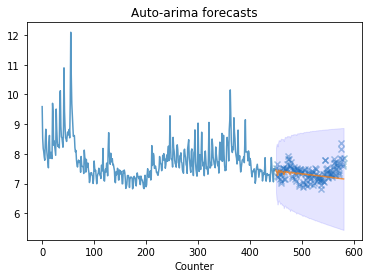

In [55]:
preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])

plt.plot(x_axis[:train.shape[0]], train, alpha=0.75)
plt.plot(x_axis[train.shape[0]:], preds, alpha=0.75)  # Forecasts
plt.scatter(x_axis[train.shape[0]:], test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Auto-arima forecasts")
plt.xlabel("Counter")

In [59]:
#What a plain forecast output would look like without appending to validation set. The actual output we would get assuming evaluation would happen in a seperate image. 
forecast = model.predict(n_periods=(len(test)))
forecast = pd.DataFrame(forecast, columns=['Prediction'])
forecast.tail()


,Prediction
126,7.162686
127,7.160198
128,7.157393
129,7.155969
130,7.153794
